<a href="https://colab.research.google.com/github/dangduong2806/google-colab/blob/main/Results_BiLSTM_assisted_by_distilBert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
uploaded = files.upload()

Saving best_model_distil_bert.weights.h5 to best_model_distil_bert.weights.h5


In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import pandas as pd
import transformers
from tensorflow.keras.layers import Input, Dense, Lambda

In [4]:
df = pd.read_csv("colors1.csv")
df.head()

,name,red,green,blue
0,parakeet,174,182,87
1,saddle brown,88,52,1
2,cucumber crush,222,237,215
3,pool blue,134,194,201
4,distance,98,110,130


In [5]:
df["red"] = df["red"] / 255
df["green"] = df["green"] / 255
df["blue"] = df["blue"] / 255
df.head()

,name,red,green,blue
0,parakeet,0.682353,0.713725,0.341176
1,saddle brown,0.345098,0.203922,0.003922
2,cucumber crush,0.870588,0.929412,0.843137
3,pool blue,0.525490,0.760784,0.788235
4,distance,0.384314,0.431373,0.509804


In [6]:
X_texts = df['name'].astype(str).values
y_rgb = df[['red', 'green', 'blue']].values

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
# Tách train/val
X_train, X_val, y_train, y_val = train_test_split(
    X_texts, y_rgb, test_size=0.2, shuffle = True, random_state=42
)

In [9]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
def tokenize_text(texts):
    texts = list(texts)
    encodings = tokenizer(texts, padding=True, truncation=True, return_tensors="tf")
    return {
        "input_ids": encodings["input_ids"],
        "attention_mask": encodings["attention_mask"]
    }

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [48]:
import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer

def create_distilbert_assisted_bilstm(trained_weights_path):
    """
    Create a BiLSTM model assisted by your trained DistilBERT

    Args:
        trained_weights_path: Path to your trained DistilBERT weights (.h5 file)

    Returns:
        Compiled Keras model
    """
    # Load fresh DistilBERT model
    distilbert_layer = TFAutoModel.from_pretrained('distilbert-base-uncased', return_dict= True)

    # Create a temporary model with same structure as your trained model to load weights
    temp_input_ids = tf.keras.Input(shape=(None,), dtype=tf.int32, name="input_ids")
    temp_attention_mask = tf.keras.Input(shape=(None,), dtype=tf.int32, name="attention_mask")

    # temp_cls_token = tf.keras.layers.Lambda(
    #     lambda x: distilbert_layer(input_ids=x[0], attention_mask=x[1]).last_hidden_state[:, 0, :],
    #     output_shape=(768,)
    # )([temp_input_ids, temp_attention_mask])
    temp_cls_token = tf.keras.layers.Lambda(
    lambda x: distilbert_layer(input_ids=x['input_ids'], attention_mask=x['attention_mask']).last_hidden_state[:, 0, :],
    output_shape=(768,)
    )([temp_input_ids, temp_attention_mask])

    temp_x = tf.keras.layers.Dense(128, activation="relu")(temp_cls_token)
    temp_x = tf.keras.layers.Dense(3, activation="sigmoid")(temp_x)

    temp_model = tf.keras.Model(inputs=[temp_input_ids, temp_attention_mask], outputs=temp_x)

    # Load your trained weights
    temp_model.load_weights(trained_weights_path)

    # Extract the trained DistilBERT layer
    trained_distilbert_layer = temp_model.layers[2]  # The DistilBERT layer

    # Freeze the trained DistilBERT layer for feature extraction only
    trained_distilbert_layer.trainable = False

    # Define new inputs
    input_ids = tf.keras.Input(shape=(None,), dtype=tf.int32, name="input_ids")
    attention_mask = tf.keras.Input(shape=(None,), dtype=tf.int32, name="attention_mask")

    # # Get DistilBERT features for all tokens using the trained layer
    distilbert_output = trained_distilbert_layer({'input_ids': input_ids, 'attention_mask': attention_mask})
    sequence_features = distilbert_output # Shape: (batch, seq_len, 768)
    sequence_features = tf.keras.layers.Reshape((1, 768))(sequence_features)

    # BiLSTM processes the DistilBERT features
    bilstm_output = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(128, return_sequences=False, dropout=0.1),
        name="assisted_bilstm"
    )(sequence_features)

    # Add some regularization
    x = tf.keras.layers.Dropout(0.2)(bilstm_output)
    x = tf.keras.layers.Dense(128, activation="relu", name="bilstm_dense1")(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Dense(64, activation="relu", name="bilstm_dense2")(x)

    # Final RGB output
    rgb_output = tf.keras.layers.Dense(3, activation="sigmoid", name="rgb_output")(x)

    # Create the model
    model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=rgb_output)

    # Compile with appropriate settings for BiLSTM training
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),  # Higher LR for new layers
        loss='mse',
        metrics=['mae']
    )
    return model

In [41]:
# Training function
def train_assisted_bilstm(model, train_tokens, y_train, val_tokens, y_val, epochs):
    """
    Train the DistilBERT-assisted BiLSTM model
    """
    # Setup callbacks
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        'best_assisted_bilstm_model.weights.h5',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only = True,
        mode = 'min',
        verbose = 1
    )

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        patience=10,
        restore_best_weights=True,
        monitor='val_loss'
    )

    # Train the model
    history = model.fit(
        train_tokens,
        y_train,
        validation_data=(val_tokens, y_val),
        epochs=epochs,
        batch_size=16,
        shuffle=True,
        callbacks=[checkpoint, reduce_lr, early_stopping]
    )

    return history

In [12]:
train_tokens = tokenize_text(X_train)
val_tokens = tokenize_text(X_val)

In [49]:
assisted_model = create_distilbert_assisted_bilstm('best_model_distil_bert.weights.h5')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [50]:
history = train_assisted_bilstm(
    assisted_model,
    train_tokens, y_train,
    val_tokens, y_val,
    epochs=70
)

Epoch 1/70
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0605 - mae: 0.2059
Epoch 1: val_loss improved from inf to 0.04866, saving model to best_assisted_bilstm_model.weights.h5
718/718 ━━━━━━━━━━━━━━━━━━━━ 33s 30ms/step - loss: 0.0605 - mae: 0.2058 - val_loss: 0.0487 - val_mae: 0.1813 - learning_rate: 0.0010
Epoch 2/70
716/718 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0493 - mae: 0.1807
Epoch 2: val_loss improved from 0.04866 to 0.04682, saving model to best_assisted_bilstm_model.weights.h5
718/718 ━━━━━━━━━━━━━━━━━━━━ 34s 24ms/step - loss: 0.0493 - mae: 0.1807 - val_loss: 0.0468 - val_mae: 0.1790 - learning_rate: 0.0010
Epoch 3/70
716/718 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0463 - mae: 0.1737
Epoch 3: val_loss improved from 0.04682 to 0.04485, saving model to best_assisted_bilstm_model.weights.h5
718/718 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 0.0463 - mae: 0.1737 - val_loss: 0.0448 - val_mae: 0.1727 - learning_rate: 0.0010
Epoch 4/70
717/718 ━━━━━━━━━━━━━━━━━━━━ 0

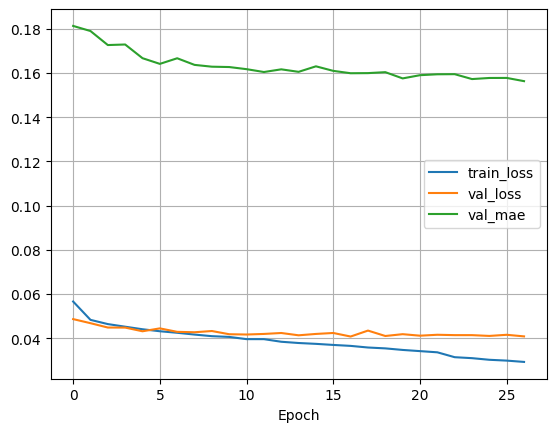

In [51]:

import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['val_mae'], label='val_mae')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [52]:
def scale(n):
    return int(n * 255)

In [53]:
def plot_rgb(rgb):
    data = [[rgb]]
    plt.figure(figsize=(2, 2))
    plt.imshow(data, interpolation='nearest')
    plt.show()

In [54]:
def predict(name):
    name = name.lower()
    # Tokenize input (chuẩn cho BERT)
    encoded = tokenizer(
        name,
        padding='max_length',
        truncation=True,
        max_length=16,  # hoặc dài hơn nếu bạn muốn
        return_tensors='tf'
    )

    # Dự đoán RGB
    pred = assisted_model.predict({
        "input_ids": encoded["input_ids"],
        "attention_mask": encoded["attention_mask"]
    }, verbose=0)[0]  # lấy [0] vì chỉ có 1 mẫu

    # Scale về 0-255
    r, g, b = scale(pred[0]), scale(pred[1]), scale(pred[2])

    print(name + ',', 'R,G,B:', r, g, b)
    plot_rgb(pred)

Lemon Yellow
lemon yellow, R,G,B: 249 236 83


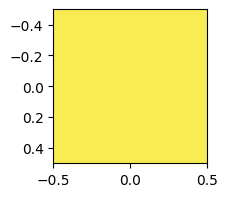

In [55]:
n = input()
predict(n)

Sky Blue
sky blue, R,G,B: 151 203 224


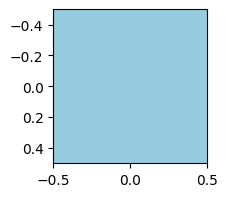

In [56]:
n = input()
predict(n)

Cucumber
cucumber, R,G,B: 186 160 129


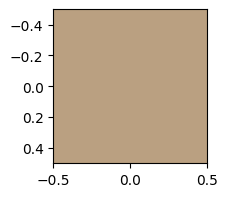

In [57]:
n = input()
predict(n)

Ocean
ocean, R,G,B: 67 163 167


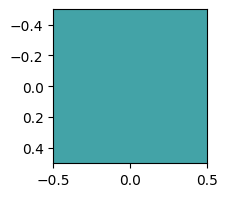

In [58]:
n = input()
predict(n)

Red
red, R,G,B: 180 19 28


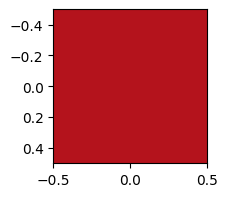

In [59]:
n = input()
predict(n)

Abandoned Red
abandoned red, R,G,B: 153 71 73


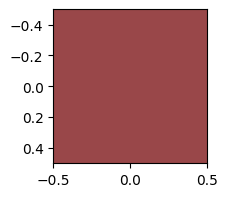

In [60]:
n = input()
predict(n)

Absolute Red
absolute red, R,G,B: 172 34 56


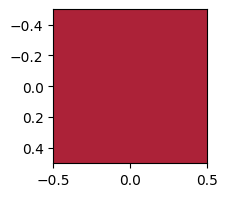

In [61]:
n = input()
predict(n)

Pink
pink, R,G,B: 241 160 188


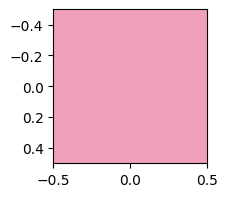

In [62]:
n = input()
predict(n)

Purple
purple, R,G,B: 125 61 166


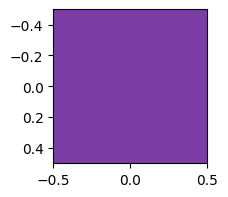

In [63]:
n = input()
predict(n)

Green
green, R,G,B: 69 138 44


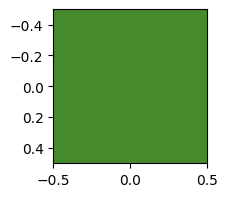

In [64]:
n = input()
predict(n)

Orange
orange, R,G,B: 232 107 28


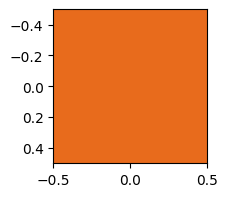

In [65]:
n = input()
predict(n)

Evaluate

In [66]:
X_train, X_val, y_train, y_val = train_test_split(
    X_texts, y_rgb, test_size=0.3, shuffle = True, random_state=42
)

In [67]:
assisted_model.load_weights("best_assisted_bilstm_model.weights.h5")

In [68]:
X_val_2 = tokenize_text(X_val)

In [69]:
y_pred = assisted_model.predict(X_val_2)

135/135 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step


In [70]:
!pip install colormath

  Preparing metadata (setup.py) ... done
  Created wheel for colormath: filename=colormath-3.0.0-py3-none-any.whl size=39405 sha256=1c5981b48e7b46e24f29677777dafc328d78807c4c52a693340d2f3bc7547a7e
  Stored in directory: /root/.cache/pip/wheels/f5/ce/f7/7039d7b57e1a27fc2f6bb2b2abed1be362eefece03caf2fb9a
Successfully built colormath


In [71]:
from colormath.color_objects import LabColor, sRGBColor
from colormath.color_conversions import convert_color
from colormath.color_diff import delta_e_cie2000
import numpy as np
if not hasattr(np, 'asscalar'):
    np.asscalar = lambda x: x.item()

def compute_ciede2000_each_point(y_true, y_pred):
    delta_e_list = []
    for true_rgb, pred_rgb in zip(y_true, y_pred):
        c1 = sRGBColor(*true_rgb, is_upscaled=True)
        c2 = sRGBColor(*pred_rgb, is_upscaled=True)
        lab1 = convert_color(c1, LabColor)
        lab2 = convert_color(c2, LabColor)
        delta_e = float(delta_e_cie2000(lab1, lab2))
        delta_e_list.append(delta_e)
    return delta_e_list

# Scale về [0, 255] nếu cần
y_true_scaled = np.clip(y_val * 255, 0, 255)
y_pred_scaled = np.clip(y_pred * 255, 0, 255)

delta_e_list = compute_ciede2000_each_point(y_true_scaled, y_pred_scaled)

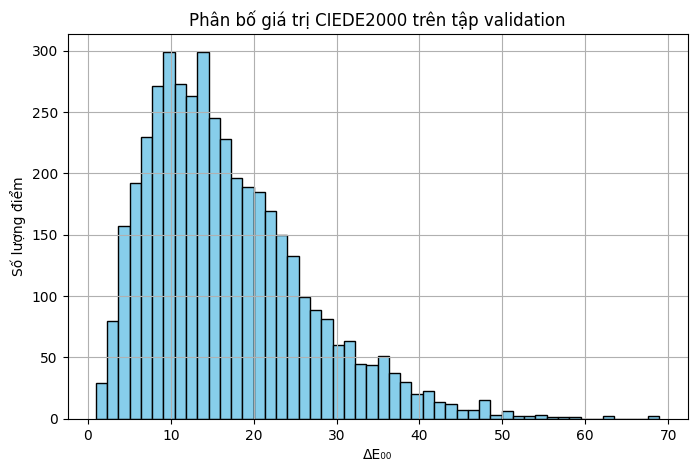

In [72]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(delta_e_list, bins=50, color='skyblue', edgecolor='black')
plt.title("Phân bố giá trị CIEDE2000 trên tập validation")
plt.xlabel("ΔE₀₀")
plt.ylabel("Số lượng điểm")
plt.grid(True)
plt.show()

In [74]:
results = assisted_model.evaluate(X_val_2, y_val)

135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 0.0401 - mae: 0.1591
